In [1]:
import pandas as pd
import numpy as np 
import requests
import json
import string
from sklearn.ensemble import RandomForestRegressor
import datetime
import feather
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from nltk.stem import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import statsmodels.api as sn 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_csv('reddit.csv')

In [3]:
data

,post_id,date,subreddit,upvotes,comm,ratio,title
0,t3_rtw91q,1641081614,Python,10,19,1.00,Sunday Daily Thread: What's everyone working o...
1,t3_rvfybl,1641254419,Python,1,0,1.00,Tuesday Daily Thread: Advanced questions
2,t3_rvahuo,1641239971,Python,76,62,0.92,How did you learn python?
3,t3_ruytfm,1641206185,Python,352,61,0.87,EMOJILANG: A programming language where you ca...
4,t3_rv8i2y,1641234803,Python,66,9,0.94,I created a tool to detect broken __slots__ in...
...,...,...,...,...,...,...,...
501,t3_rmsh5b,1640253947,deeplearning,1,3,0.67,Oddly getting a dramatic accuracy difference f...
502,t3_rmhybo,1640216397,deeplearning,4,3,0.75,What pytorch model can I use to classify a jso...
503,t3_rmdg2h,1640203297,deeplearning,5,5,0.86,Best DN architecture for multivariable time se...
504,t3_rm83lb,1640188557,deeplearning,8,0,1.00,[R] Facebook AI &amp; JHU’s MaskFeat Method Su...


(array([480.,  15.,   4.,   2.,   1.,   0.,   1.,   0.,   1.,   2.]),
 array([   0. ,  204.8,  409.6,  614.4,  819.2, 1024. , 1228.8, 1433.6,
        1638.4, 1843.2, 2048. ]),
 <BarContainer object of 10 artists>)

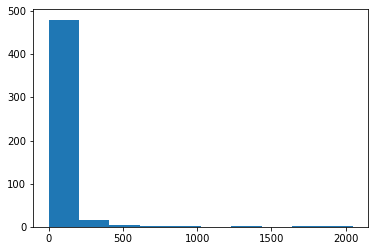

In [4]:
plt.hist(data['upvotes'])

(array([483.,  15.,   3.,   3.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  0. ,  51.6, 103.2, 154.8, 206.4, 258. , 309.6, 361.2, 412.8,
        464.4, 516. ]),
 <BarContainer object of 10 artists>)

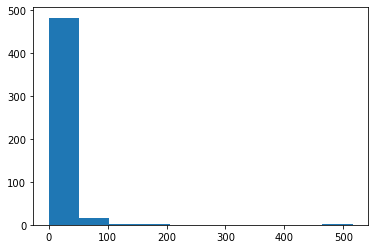

In [5]:
plt.hist(data['comm'])

<AxesSubplot:xlabel='subreddit', ylabel='upvotes'>

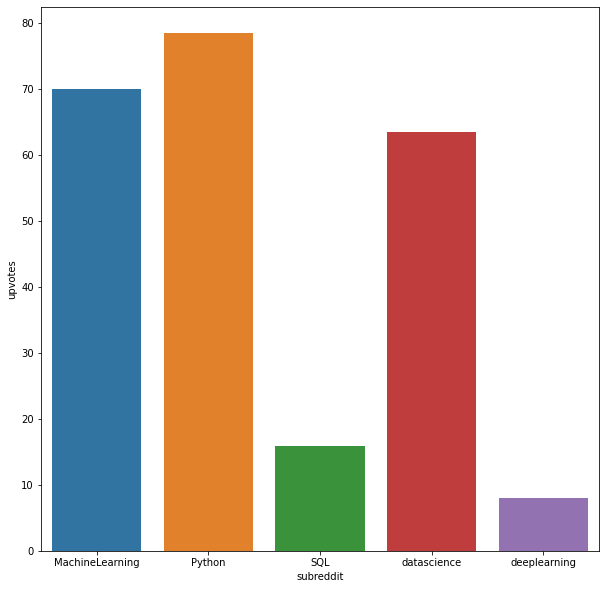

In [6]:
t = data.groupby('subreddit').mean()['upvotes']
plt.figure(figsize=(10,10))
sns.barplot(x=t.index, y=t)

In [7]:
data.isna().sum()

post_id      0
date         0
subreddit    0
upvotes      0
comm         0
ratio        0
title        0
dtype: int64

In [8]:
data['date_format'] = data['date'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [9]:
def find_quarters(hours):
    if hours <= 6:
        return 'First Quarter'
    elif hours <= 12:
        return 'Second Quarter'
    elif hours <= 18:
        return 'Third Quarter'
    elif hours <= 24:
        return 'Fourth Quarter'

In [10]:
data['hours'] = pd.DatetimeIndex(data['date_format']).hour
data['day'] = pd.DatetimeIndex(data['date_format']).day
data['Quarters'] = data['hours'].apply(lambda x: find_quarters(x)) 

In [11]:
data = pd.get_dummies(data=data, columns=['subreddit', 'Quarters'])

In [12]:
data

,post_id,date,upvotes,comm,ratio,title,date_format,hours,day,subreddit_MachineLearning,subreddit_Python,subreddit_SQL,subreddit_datascience,subreddit_deeplearning,Quarters_First Quarter,Quarters_Fourth Quarter,Quarters_Second Quarter,Quarters_Third Quarter
0,t3_rtw91q,1641081614,10,19,1.00,Sunday Daily Thread: What's everyone working o...,2022-01-01 16:00:14,16,1,0,1,0,0,0,0,0,0,1
1,t3_rvfybl,1641254419,1,0,1.00,Tuesday Daily Thread: Advanced questions,2022-01-03 16:00:19,16,3,0,1,0,0,0,0,0,0,1
2,t3_rvahuo,1641239971,76,62,0.92,How did you learn python?,2022-01-03 11:59:31,11,3,0,1,0,0,0,0,0,1,0
3,t3_ruytfm,1641206185,352,61,0.87,EMOJILANG: A programming language where you ca...,2022-01-03 02:36:25,2,3,0,1,0,0,0,1,0,0,0
4,t3_rv8i2y,1641234803,66,9,0.94,I created a tool to detect broken __slots__ in...,2022-01-03 10:33:23,10,3,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,t3_rmsh5b,1640253947,1,3,0.67,Oddly getting a dramatic accuracy difference f...,2021-12-23 02:05:47,2,23,0,0,0,0,1,1,0,0,0
502,t3_rmhybo,1640216397,4,3,0.75,What pytorch model can I use to classify a jso...,2021-12-22 15:39:57,15,22,0,0,0,0,1,0,0,0,1
503,t3_rmdg2h,1640203297,5,5,0.86,Best DN architecture for multivariable time se...,2021-12-22 12:01:37,12,22,0,0,0,0,1,0,0,1,0
504,t3_rm83lb,1640188557,8,0,1.00,[R] Facebook AI &amp; JHU’s MaskFeat Method Su...,2021-12-22 07:55:57,7,22,0,0,0,0,1,0,0,1,0


In [13]:
X_mult_linear = data[['subreddit_MachineLearning', 'subreddit_Python', 'subreddit_SQL', 'subreddit_datascience', 'subreddit_deeplearning',
       'ratio', 'comm', 'day', 'Quarters_First Quarter', 'Quarters_Fourth Quarter', 'Quarters_Second Quarter', 'Quarters_Third Quarter']]
y_mult_linear = y_forest = data['upvotes'].values
sc = StandardScaler()
sc.fit_transform(X_mult_linear,y_mult_linear)
X_sn = X_mult_linear = sn.add_constant(X_mult_linear)
model = sn.OLS(y_mult_linear,X_mult_linear)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     24.21
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           3.12e-37
Time:                        13:05:29   Log-Likelihood:                -3238.6
No. Observations:                 506   AIC:                             6499.
Df Residuals:                     495   BIC:                             6546.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -59.4784     18.279     -3.254      0.001     -95.393     -23.564
subreddit_MachineLearning    15.3654     13.432      1.144      0.253     -11.026      41.756
subreddit_Python              8.5365     13.915      0.613      0.540     -18.803      35.876
subreddit_SQL               -37.3334     13.936     -2.679      0.008     -64.714      -9.953
subreddit_datascience       -14.1289     13.523     -1.045      0.297     -40.698      12.440
subreddit_deeplearning      -31.9180     14.548     -2.194      0.029     -60.501      -3.335
ratio                       120.4644     33.065      3.643      0.000      55.499     185.430
comm                          2.4123      0.182     13.234      0.000       2.054       2.770
day                           0.5855      0.537      1.090      0.276      -0.470       1.641
Quarters_First Quarter       -3.0762     11.901     -0.258      0.796     -26.458      20.306
Quarters_Fourth Quarter     -14.6977     14.254     -1.031      0.303     -42.704      13.308
Quarters_Second Quarter     -21.5461     11.515     -1.871      0.062     -44.170       1.078
Quarters_Third Quarter      -20.1585     12.855     -1.568      0.117     -45.416       5.099
==============================================================================
Omnibus:                      715.179   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           152770.416
Skew:                           7.308   Prob(JB):                         0.00
Kurtosis:                      86.859   Cond. No.                     1.43e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.99e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
X_forest = data[['subreddit_MachineLearning', 'subreddit_Python', 'subreddit_SQL', 'subreddit_datascience', 'subreddit_deeplearning',
       'ratio', 'comm', 'day', 'Quarters_First Quarter', 'Quarters_Fourth Quarter', 'Quarters_Second Quarter', 'Quarters_Third Quarter']]
y_forest = data['upvotes'].values
X_train, X_test, y_train, y_test = train_test_split(X_forest, y_forest, test_size=.2, random_state=0)
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
np.mean(cross_val_score(forest, X_train,y_train,scoring='r2', cv=3))

0.28526353685554545

In [15]:
pn = PorterStemmer()
words = stopwords.words('English')
def clean_text(text: list) -> list:
    text = ''.join([i for i in text if i not in string.punctuation])
    tokenize = re.split('\W+',string=text)
    text = ' '.join([pn.stem(i) for i in tokenize if i not in words])
    return text

In [16]:
df = data

In [17]:
print(df['upvotes'].quantile(.75))
print(df['upvotes'].quantile(.25))
print(df['comm'].quantile(.75))
print(df['comm'].quantile(.25))
IQR_upvotes = df['upvotes'].quantile(.75) - df['upvotes'].quantile(.25)
Comm_upvotes = df['comm'].quantile(.75) - df['comm'].quantile(.25)
print("The IQR for the upvotes is ", IQR_upvotes)
print("The IQR for the comments is ", Comm_upvotes)

20.0
1.0
11.0
1.0
The IQR for the upvotes is  19.0
The IQR for the comments is  10.0


In [18]:
max_upvotes = 20 + 1.5 * IQR_upvotes 
max_comm  = 11 + 1.5 * IQR_upvotes

In [19]:
filtered_df = df[(df['upvotes'] < max_upvotes) & (df['comm'] <max_comm)]

In [20]:
filtered_df

,post_id,date,upvotes,comm,ratio,title,date_format,hours,day,subreddit_MachineLearning,subreddit_Python,subreddit_SQL,subreddit_datascience,subreddit_deeplearning,Quarters_First Quarter,Quarters_Fourth Quarter,Quarters_Second Quarter,Quarters_Third Quarter
0,t3_rtw91q,1641081614,10,19,1.00,Sunday Daily Thread: What's everyone working o...,2022-01-01 16:00:14,16,1,0,1,0,0,0,0,0,0,1
1,t3_rvfybl,1641254419,1,0,1.00,Tuesday Daily Thread: Advanced questions,2022-01-03 16:00:19,16,3,0,1,0,0,0,0,0,0,1
5,t3_rv8p8m,1641235323,28,12,0.85,Create Your First Reddit Bot with Python and H...,2022-01-03 10:42:03,10,3,0,1,0,0,0,0,0,1,0
6,t3_rv5ybi,1641228217,16,0,0.78,Secrets of MicroPython: How to read a knob,2022-01-03 08:43:37,8,3,0,1,0,0,0,0,0,1,0
7,t3_rvbcyz,1641242197,5,0,0.86,Project Althaia - looking for performance/accu...,2022-01-03 12:36:37,12,3,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,t3_rmsh5b,1640253947,1,3,0.67,Oddly getting a dramatic accuracy difference f...,2021-12-23 02:05:47,2,23,0,0,0,0,1,1,0,0,0
502,t3_rmhybo,1640216397,4,3,0.75,What pytorch model can I use to classify a jso...,2021-12-22 15:39:57,15,22,0,0,0,0,1,0,0,0,1
503,t3_rmdg2h,1640203297,5,5,0.86,Best DN architecture for multivariable time se...,2021-12-22 12:01:37,12,22,0,0,0,0,1,0,0,1,0
504,t3_rm83lb,1640188557,8,0,1.00,[R] Facebook AI &amp; JHU’s MaskFeat Method Su...,2021-12-22 07:55:57,7,22,0,0,0,0,1,0,0,1,0


In [21]:
X_mult_linear = filtered_df[['subreddit_MachineLearning', 'subreddit_Python', 'subreddit_SQL', 'subreddit_datascience', 'subreddit_deeplearning',
       'ratio', 'comm', 'day', 'Quarters_First Quarter', 'Quarters_Fourth Quarter', 'Quarters_Second Quarter', 'Quarters_Third Quarter']]
y_mult_linear = y_forest = filtered_df['upvotes'].values
sc = StandardScaler()
sc.fit_transform(X_mult_linear,y_mult_linear)
X_sn = X_mult_linear = sn.add_constant(X_mult_linear)
model = sn.OLS(y_mult_linear,X_mult_linear)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     22.41
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           1.58e-33
Time:                        13:05:30   Log-Likelihood:                -1478.1
No. Observations:                 426   AIC:                             2978.
Df Residuals:                     415   BIC:                             3023.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -7.9339      1.039     -7.633      0.000      -9.977      -5.891
subreddit_MachineLearning     0.9135      0.820      1.115      0.266      -0.698       2.525
subreddit_Python              1.3726      0.829      1.656      0.099      -0.257       3.002
subreddit_SQL                -4.3648      0.813     -5.372      0.000      -5.962      -2.767
subreddit_datascience        -2.4967      0.821     -3.042      0.002      -4.110      -0.884
subreddit_deeplearning       -3.3586      0.839     -4.005      0.000      -5.007      -1.710
ratio                        20.7422      1.923     10.786      0.000      16.962      24.522
comm                          0.4507      0.059      7.702      0.000       0.336       0.566
day                           0.0673      0.032      2.128      0.034       0.005       0.130
Quarters_First Quarter       -1.6589      0.694     -2.391      0.017      -3.023      -0.295
Quarters_Fourth Quarter      -1.6943      0.845     -2.004      0.046      -3.356      -0.032
Quarters_Second Quarter      -1.7626      0.668     -2.638      0.009      -3.076      -0.449
Quarters_Third Quarter       -2.8181      0.754     -3.739      0.000      -4.300      -1.336
==============================================================================
Omnibus:                      150.632   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.784
Skew:                           1.672   Prob(JB):                     2.90e-99
Kurtosis:                       6.793   Cond. No.                     8.28e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.99e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [31]:
X_forest = filtered_df[['subreddit_MachineLearning', 'subreddit_Python', 'subreddit_SQL', 'subreddit_datascience', 'subreddit_deeplearning',
       'ratio', 'comm', 'day', 'Quarters_First Quarter', 'Quarters_Fourth Quarter', 'Quarters_Second Quarter', 'Quarters_Third Quarter']]
y_forest = filtered_df['upvotes'].values
X_train, X_test, y_train, y_test = train_test_split(X_forest, y_forest, test_size=.2, random_state=0)
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
np.mean(cross_val_score(forest, X_train,y_train,scoring='r2', cv=3))

0.4209741005825529

In [23]:
pn = PorterStemmer()
words = stopwords.words('English')
def clean_text(text: list) -> list:
    text = ''.join([i for i in text if i not in string.punctuation])
    tokenize = re.split('\W+',string=text)
    text = ' '.join([pn.stem(i) for i in tokenize if i not in words])
    return text
data['cleaned_text'] = data['title'].apply(lambda x: clean_text(x))

cn = CountVectorizer()
X_word_count = cn.fit_transform(data['cleaned_text'])
word_gram_df = pd.DataFrame(X_word_count.toarray())
word_gram_df.columns = cn.get_feature_names()


In [24]:
word_gram_df

,01,02,09,10,100,128,14,15000,1980,20,...,your,yourtt,youtub,yr,yuval,zero,zeroshot,zillow,zip,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
def get_top_n_words(corpus, n=None):   
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [26]:
get_top_n_words(df['cleaned_text'])

[('data', 69),
 ('learn', 61),
 ('python', 58),
 ('use', 50),
 ('how', 39),
 ('sql', 37),
 ('paper', 33),
 ('what', 31),
 ('model', 30),
 ('code', 21),
 ('project', 21),
 ('machin', 21),
 ('is', 21),
 ('best', 20),
 ('deep', 20),
 ('ai', 18),
 ('look', 17),
 ('question', 16),
 ('scienc', 16),
 ('like', 16),
 ('imag', 16),
 ('the', 15),
 ('2021', 15),
 ('anyon', 15),
 ('work', 14),
 ('program', 14),
 ('gener', 14),
 ('help', 14),
 ('would', 13),
 ('need', 13),
 ('tool', 12),
 ('read', 12),
 ('applic', 12),
 ('2022', 12),
 ('one', 12),
 ('time', 12),
 ('research', 12),
 ('tabl', 12),
 ('function', 11),
 ('databas', 11),
 ('ml', 11),
 ('queri', 11),
 ('thread', 10),
 ('languag', 10),
 ('creat', 10),
 ('job', 10),
 ('video', 10),
 ('librari', 9),
 ('perform', 9),
 ('approach', 9),
 ('develop', 9),
 ('get', 9),
 ('differ', 9),
 ('new', 9),
 ('vision', 9),
 ('neural', 9),
 ('analysi', 8),
 ('make', 8),
 ('made', 8),
 ('build', 8),
 ('idea', 8),
 ('file', 8),
 ('web', 8),
 ('visual', 8),
 ('u